# **Mount to google drive**

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **Imports**

In [179]:
import os
import cv2 
import sys
import numpy as np
import seaborn as sns
from time import time
from skimage.io import imread
from pickle import dump,load
from os.path import splitext
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

from keras import models
from keras.utils import Sequence,plot_model
from keras.models import load_model
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Cropping2D,BatchNormalization
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# **Generate Train and Text data from long images**

In [33]:
inputImagePath = "/content/gdrive/MyDrive/Data transfer/Dataset/Input"
groundTruthPath = "/content/gdrive/MyDrive/Data transfer/Dataset/GroundTruth"
trainDir = "/content/gdrive/MyDrive/Data transfer/Dataset/SquareTrain"
validationDir = "/content/gdrive/MyDrive/Data transfer/Dataset/SquareValidation"
testDir = "/content/gdrive/MyDrive/Data transfer/Dataset/SquareTest"
patchMargin=41
patchStep=41

In [34]:
counter = 0 
def makeData(index,dir):
    global counter
    # read image and scale
    im = imread(f'{inputImagePath}/TRAN0{index}.png')[:patchMargin*2+1,:]
    gt = imread(f'{groundTruthPath}/TRAN0{index}.png')[:patchMargin*2+1,:]    
    #     
    colIndexes = np.array(range(patchMargin,im.shape[1]-patchMargin,patchStep))
    for column in colIndexes:
        cropIm = im[:,column-patchMargin:column+patchMargin+1]
        cropGT = gt[:,column-patchMargin:column+patchMargin+1]    
        cv2.imwrite(f'{dir}/image/img/{counter}.png', cropIm)
        cv2.imwrite(f'{dir}/mask/img/{counter}.png', cropGT)
        counter += 1      
# for train
for imageIndex in [0,1,2,3,4,5,6,7]:
    makeData(imageIndex,trainDir)  
# for validation
makeData(8,validationDir)  
# for test
makeData(9,testDir)  

# **Build generator**

In [115]:
batch_size = 10

In [116]:
class DataGenerator(Sequence):
    def __init__(self, image_generator, mask_generator):        
        self.image_generator = image_generator    
        self.mask_generator = mask_generator    

    def __len__(self):
        return len(self.image_generator)        
    
    def __getitem__(self, index):        
        imgs = self.image_generator[index] # self.image_generator.next()
        masks = self.mask_generator[index] #self.mask_generator.next()                
        processed_masks = []
        for i in range(masks.shape[0]):                                   
            processed_masks.append(to_categorical(np.round(masks[i]*2.0).astype('int'),num_classes=3))                                
        return (imgs, np.array( processed_masks))

In [117]:
def getGenerator(pathDir, seed=0):    
    image_datagen = ImageDataGenerator(rescale=1./255,width_shift_range=0,height_shift_range=0) 
    mask_datagen = ImageDataGenerator(rescale=1./255,width_shift_range=0,height_shift_range=0)
    image_generator =image_datagen.flow_from_directory(f"{pathDir}/image/",
                                                     color_mode="grayscale",
                                                     target_size=(83, 83),
                                                     batch_size=batch_size,
                                                     class_mode=None, seed=seed)

    mask_generator = mask_datagen.flow_from_directory(f"{pathDir}/mask/",
                                                    color_mode="grayscale",
                                                    target_size=(83, 83),                                                                                                        
                                                    batch_size=batch_size,                                                   
                                                    class_mode=None, seed=seed)

    return DataGenerator(image_generator, mask_generator)


## **Train, Validation, Test generator**

In [118]:
print("Train:")
train_generator = getGenerator(trainDir, seed=0)
print("Validation:")
validation_generator = getGenerator(validationDir, seed=10)
print("Test:")
test_generator = getGenerator(testDir, seed=20)

Train:
Found 958 images belonging to 1 classes.
Found 958 images belonging to 1 classes.
Validation:
Found 60 images belonging to 1 classes.
Found 60 images belonging to 1 classes.
Test:
Found 60 images belonging to 1 classes.
Found 60 images belonging to 1 classes.


# **Model**

## **Create a model**

In [119]:
model = models.Sequential([
            Conv2D(16, (3, 3), activation='relu', padding='same',input_shape=(83,83,1)),
            BatchNormalization(),
            MaxPooling2D((2, 2), padding='same'),
            Conv2D(8, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2), padding='same'),
            Conv2D(8, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            MaxPooling2D((2, 2), padding='same'),

            Conv2D(8, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2, 2)),
            Conv2D(8, (3, 3), activation='relu',padding='same'),
            BatchNormalization(),
            UpSampling2D((2, 2)),
            Conv2D(16, (3, 3), activation='relu', padding='same'),
            UpSampling2D((2, 2)),
            Conv2D(3, (3, 3), activation='softmax', padding='same'),            
            Cropping2D(cropping=((3, 2), (3, 2)))
            ])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_106 (Conv2D)          (None, 83, 83, 16)        160       
_________________________________________________________________
batch_normalization_5 (Batch (None, 83, 83, 16)        64        
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 42, 42, 16)        0         
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 42, 42, 8)         1160      
_________________________________________________________________
batch_normalization_6 (Batch (None, 42, 42, 8)         32        
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 21, 21, 8)         0         
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 21, 21, 8)       

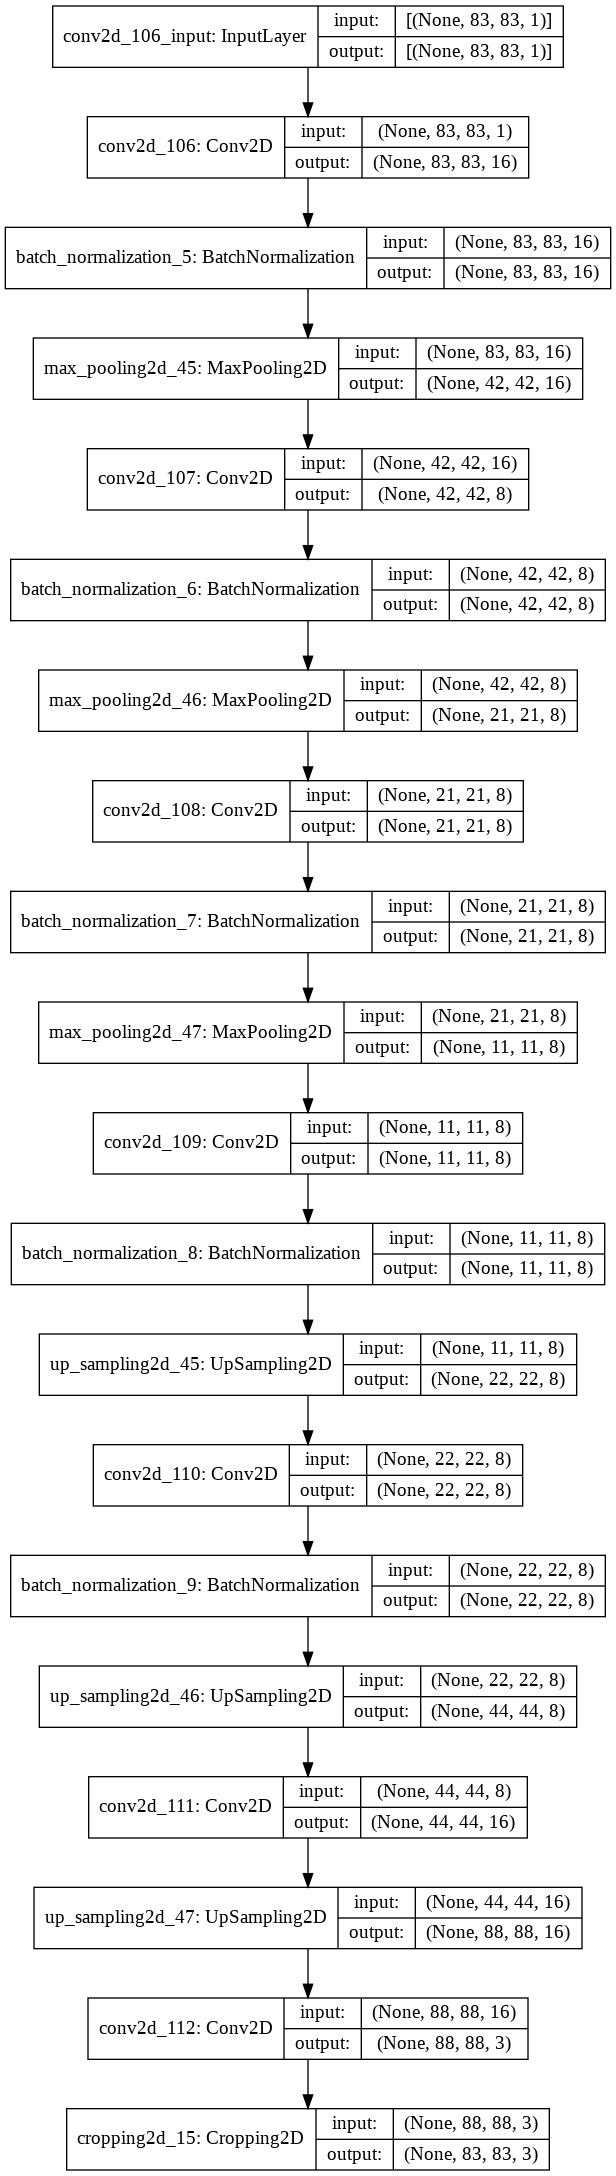

In [216]:
plot_model(model, "/content/gdrive/MyDrive/Data transfer/model.png", show_shapes=True)

## Train the model

In [122]:
epochs = 100
start_time = time()
history = model.fit_generator(train_generator,
                                      epochs=epochs,
                                      validation_data=validation_generator).history
print(f'Train time : {time()- start_time}')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
96/96 [==============================] - 4s 34ms/step - loss: 0.7003 - accuracy: 0.7067 - val_loss: 2.8570 - val_accuracy: 0.6474
Epoch 2/100
96/96 [==============================] - 3s 31ms/step - loss: 0.4094 - accuracy: 0.8350 - val_loss: 3.8231 - val_accuracy: 0.6474
Epoch 3/100
96/96 [==============================] - 3s 31ms/step - loss: 0.3557 - accuracy: 0.8590 - val_loss: 4.2226 - val_accuracy: 0.6474
Epoch 4/100
96/96 [==============================] - 3s 31ms/step - loss: 0.3280 - accuracy: 0.8720 - val_loss: 2.5832 - val_accuracy: 0.6511
Epoch 5/100
96/96 [==============================] - 3s 31ms/step - loss: 0.3059 - accuracy: 0.8794 - val_loss: 0.8781 - val_accuracy: 0.7132
Epoch 6/100
96/96 [==============================] - 3s 31ms/step - loss: 0.3093 - accuracy: 0.8791 - val_loss: 0.5593 - val_accuracy: 0.7858
Epoch 7/100
96/96 [==============================] - 3s 31ms/step - loss: 0.2961 - accuracy: 0.8831 - val_loss: 0.2367 - val_accuracy: 0.9131
Epoch 

In [123]:
model.save('/content/gdrive/MyDrive/Data transfer/model.h5')
with open('/content/gdrive/MyDrive/Data transfer/history.pkl','wb') as file:
    dump(history,file)

# **Show Result**

In [124]:
model = load_model('/content/gdrive/MyDrive/Data transfer/model.h5')        
with open('/content/gdrive/MyDrive/Data transfer/history.pkl','rb') as file:
    history = load(file)

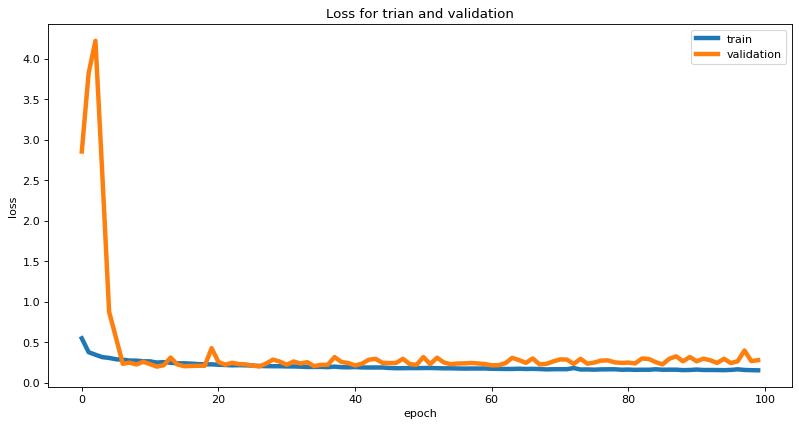

In [133]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(history['loss'],linewidth=4)
plt.plot(history['val_loss'],linewidth=4)
plt.title("Loss for trian and validation")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','validation'], loc='upper right')
plt.show()            

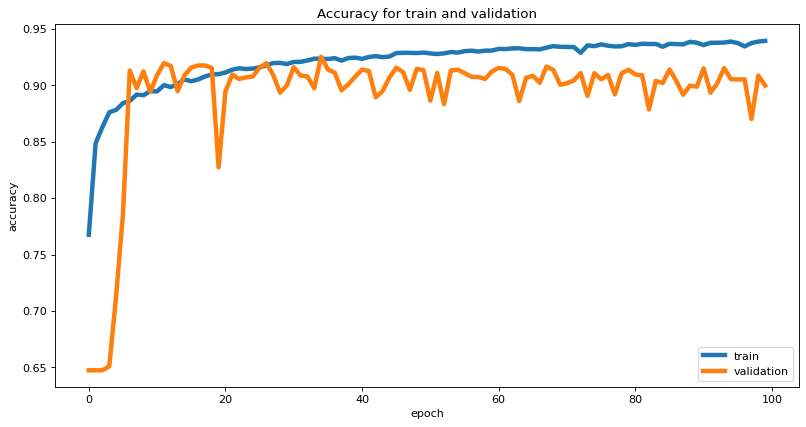

In [131]:
plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.title("Accuracy for train and validation")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(history['accuracy'],linewidth=4)
plt.plot(history['val_accuracy'],linewidth=4)
plt.legend(['train','validation'], loc='lower right')
plt.show()

In [182]:
def show_confusion_matrix(matrix):
    LABELS = ['Rock','Sand','Others']
    plt.figure(figsize=(8, 8))
    sns.heatmap(matrix,cmap="Blues",linecolor='white',linewidths=1,
                xticklabels=LABELS, yticklabels=LABELS, annot=True,fmt=".2f")    
    plt.title("Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()

In [183]:
# for true label
y_true = [] 
for ii in range(len(test_generator)):    
    y_test = test_generator[ii][1]
    for i in range(y_test.shape[0]):
        for j in range(y_test.shape[1]):
            for k in range(y_test.shape[2]):
                y_true.append(np.argmax(y_test[i][j][k]))

# for predication                 
pred = model.predict_generator(test_generator, steps=len(test_generator))
y_pred = []
for i in range(pred.shape[0]):
    for j in range(pred.shape[1]):
        for k in range(pred.shape[2]):
            y_pred.append(np.argmax(pred[i][j][k]))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


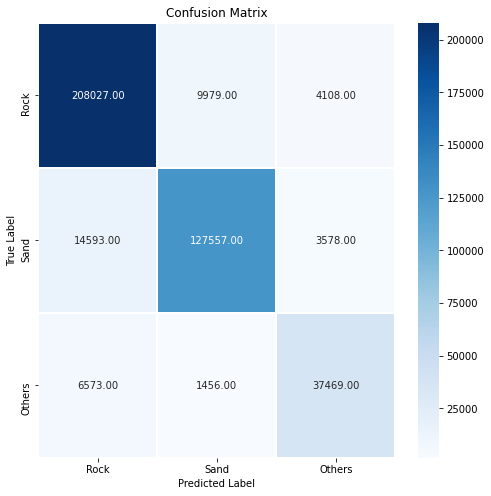

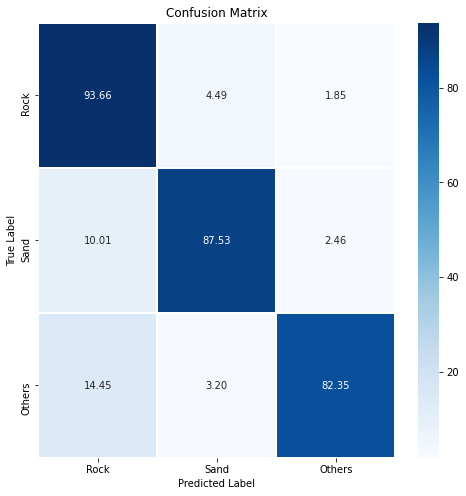

In [184]:
matrix = confusion_matrix(y_true, y_pred)
show_confusion_matrix(matrix)
sensitivity =  np.divide(matrix.transpose(),np.sum(matrix, axis=1)).transpose() * 100
show_confusion_matrix(sensitivity)

In [185]:
print(classification_report(y_true, y_pred,digits=4))

              precision    recall  f1-score   support

           0     0.9076    0.9366    0.9219    222114
           1     0.9177    0.8753    0.8960    145728
           2     0.8298    0.8235    0.8266     45498

    accuracy                         0.9025    413340
   macro avg     0.8851    0.8785    0.8815    413340
weighted avg     0.9026    0.9025    0.9023    413340



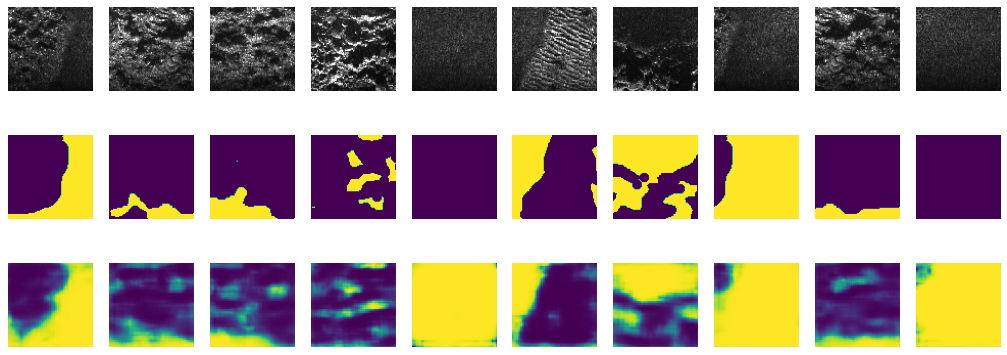

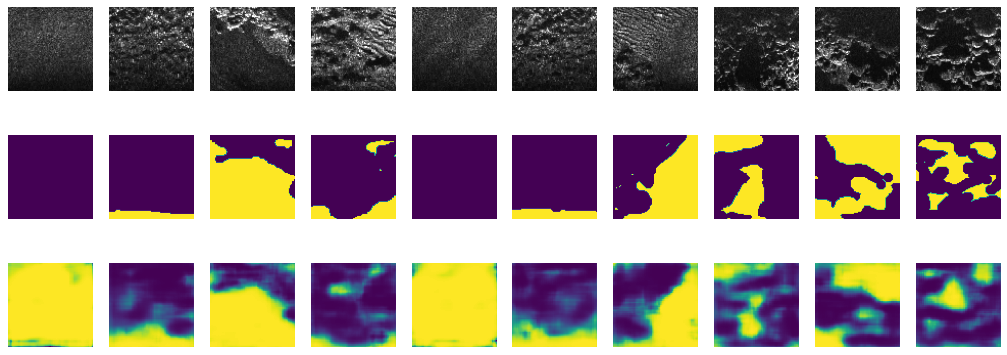

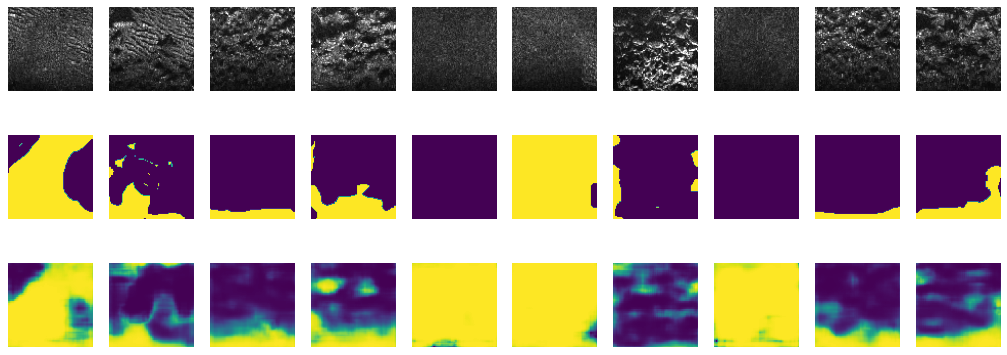

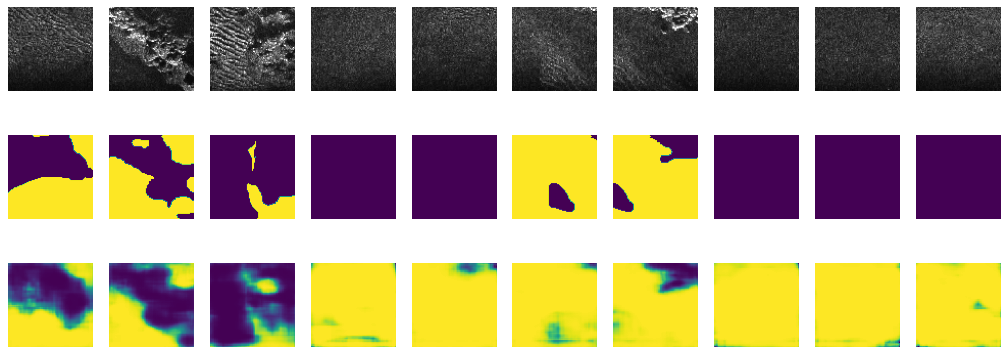

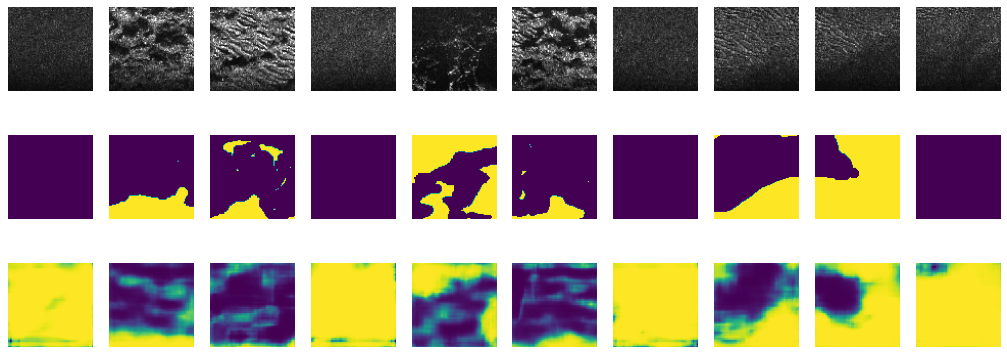

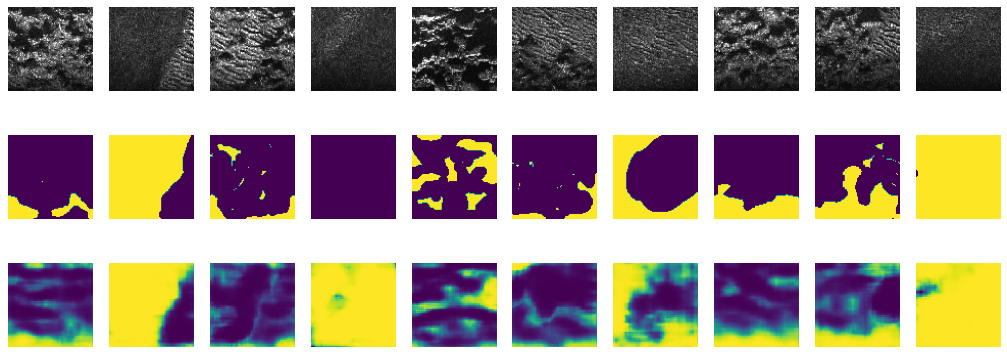

In [209]:
for ii in range(len(test_generator)):    
    plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
    images = test_generator[ii][0]
    ground_truth = test_generator[ii][1]
    pred = model.predict_on_batch(test_generator[ii][0])
    n = images.shape[0] # 10
    for i in range(n):
        plt.subplot(3,n,i+1)
        plt.imshow(images[i,:,:,0],cmap='gray',vmin=0,vmax=1)
        plt.axis('off')
        plt.subplot(3,n, n+i+1)
        plt.imshow(ground_truth[i,:,:,0])
        plt.axis('off')
        plt.subplot(3,n,n+n+i+1)
        plt.imshow(pred[i,:,:,0])
        plt.axis('off')    
    plt.show()        